In [1]:
import os
import random
import cPickle as pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import skimage.io

import caffe

from lib import run_net
from lib import score_util
from lib import plot_util

from datasets.nyud_seg import nyud

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (12, 12)

Configure Caffe

In [2]:
caffe.set_device(0)
caffe.set_mode_gpu()

NYUDv2 segmentation set details

(-0.5, 559.5, 424.5, -0.5)

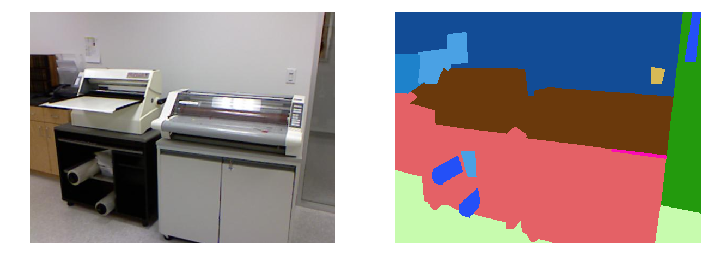

In [3]:
NY = nyud('/x/nyud')

# NYUDv2 dir and splits
splits_f = NY.dir + '/splits.pkl'
if os.path.exists(splits_f):
    image_sets = pickle.load(open(splits_f, 'r'))
else:
    splits = ['train', 'val', 'test']
    image_sets = {}
    for split in splits:
        image_sets[split] = []
        idxs = scipy.io.loadmat('{}/{}.mat'.format(NY.dir, split))['split_ids'][0]
        for idx in idxs:
            image_sets[split].append(re.findall('\d+', idx[0])[0])
        random.shuffle(image_sets[split])
    pickle.dump(image_sets, open(splits_f, 'w'))

# union trainval
image_sets['trainval'] = image_sets['train'] + image_sets['val']

# demo
im_idx = image_sets['train'][0]
demo_im = NY.load_seg_image(im_idx)
demo_segm = NY.load_label(im_idx)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(demo_im)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(demo_segm, cmap=plot_util.segm_cmap, vmin=0, vmax=40)
plt.axis('off')

Load fcn8s and sanity check on an NYUDv2 image

In [4]:
net = caffe.Net('../nets/nyud-fcn8s.prototxt', '../nets/fcn8s-nyud-rgb-heavy.caffemodel', caffe.TEST)

Inspect output on 10 random test images.

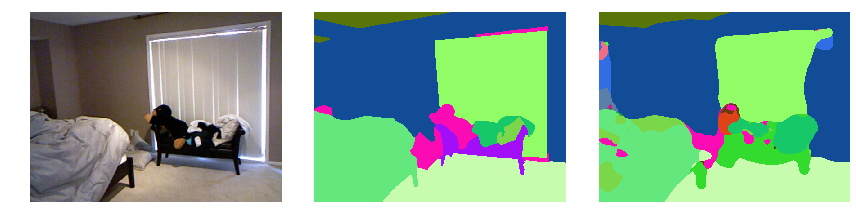

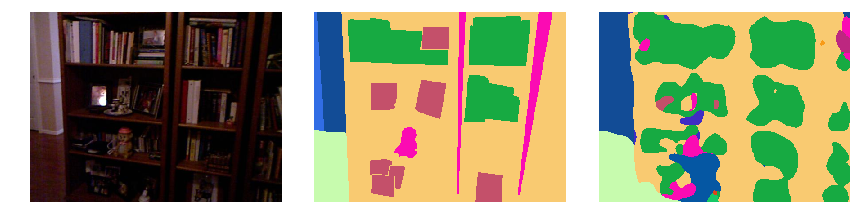

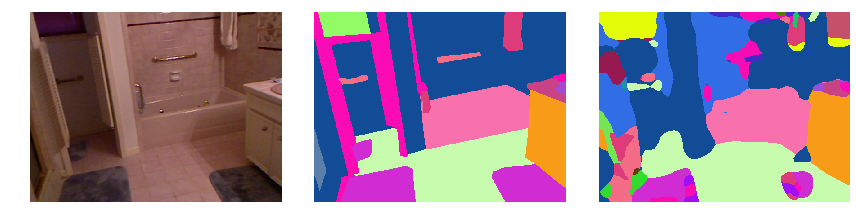

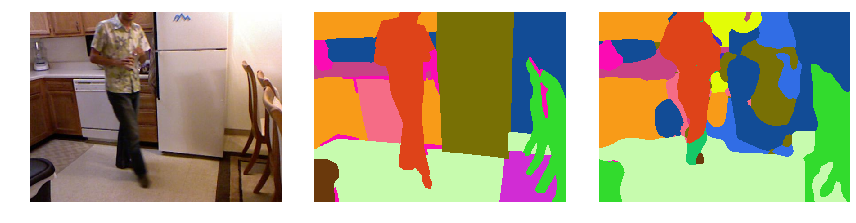

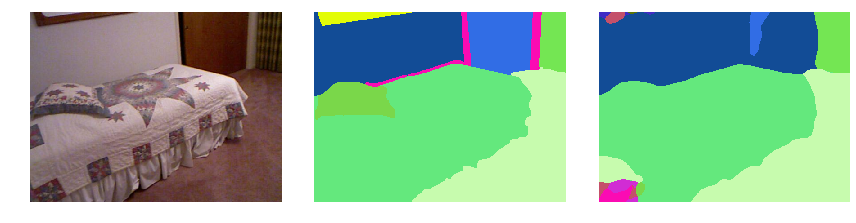

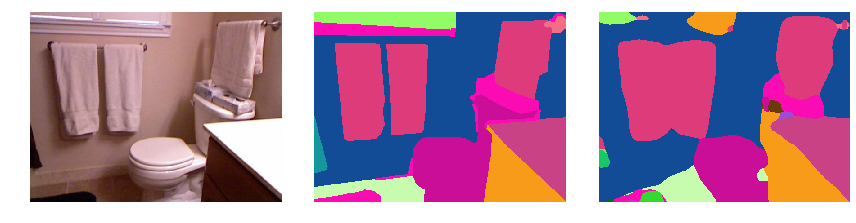

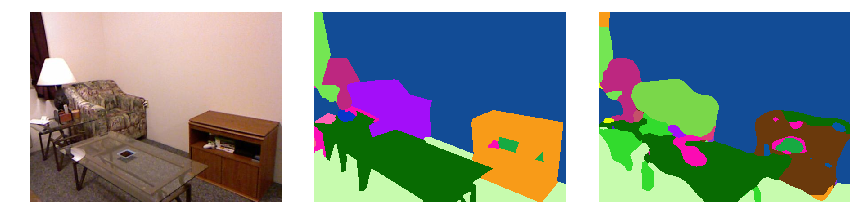

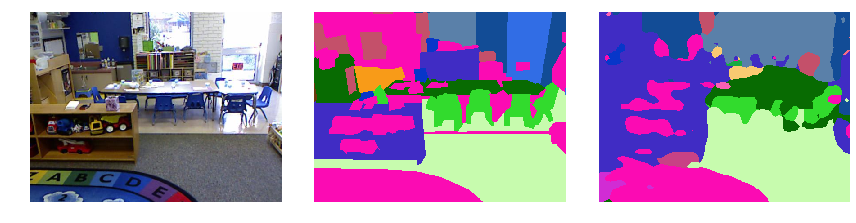

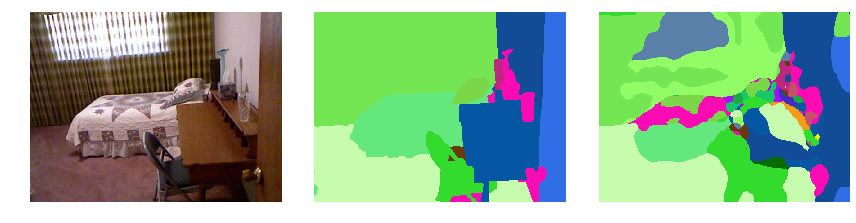

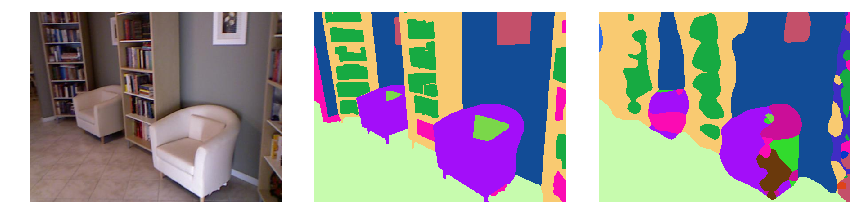

In [5]:
for i in range(10):
    idx = random.choice(image_sets['test'])
    im, label = NY.load_seg_image(idx), NY.load_label(idx)
    out = run_net.segrun(net, NY.preprocess(im))
    plot_util.segshow(im, label, out, n_cl=40)

Check mean IU over test set.

In [6]:
hist = np.zeros((40, 40))
for i, idx in enumerate(image_sets['test']):
    im, label = NY.load_seg_image(idx), NY.load_label(idx)
    out = run_net.segrun(net, NY.preprocess(im))
    hist += score_util.fast_hist(label.flatten(), out.flatten(), 40)

accP, cl_accP, mean_iuP, fw_iuP = score_util.get_scores(hist)
print 'Oracle: Per frame'
print 'acc\t\t cl acc\t\t mIU\t\t fwIU'
print '{:f}\t {:f}\t {:f}\t {:f}\t'.format(100*accP, 100*cl_accP, 100*mean_iuP, 100*fw_iuP)

Oracle: Per frame
acc		 cl acc		 mIU		 fwIU
62.422263	 45.213691	 31.972306	 46.873424	
